## Focus on rare cell-cluster

In [2]:
# Import useful modules

import numpy as np
import pandas as pd
import scanpy as sc
import os
#import igraph
import matplotlib.pyplot as plt
import seaborn

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=90)

scanpy==1.4+39.gc70f24b anndata==0.6.18 numpy==1.16.2 scipy==1.2.1 pandas==0.24.1 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 


In [3]:
# Load the integrated and annotated dataset
adata_ann = sc.read_h5ad('/Data/Annotated_dataset_v1.h5ad')

# Load non-integrated & pre-processed dataset
adata_raw = sc.read_h5ad('/Data/PreProcessed_preliminary_dataset.h5ad')

In [21]:
# Transfer annotation onto a non-data integrated anndata object.
adata = adata_raw[adata_ann.obs.index.tolist(), ]
adata.obs['cell_type'] = adata_ann.obs['cell_type']

In [22]:
# Select cells
list_of_cell_names = adata.obs.loc[adata.obs['cell_type'] == 'Rare cells', :].index.tolist()
adata = adata[list_of_cell_names, ]
adata.shape

(362, 32568)

In [23]:
# Remove unwanted genes (mitochondrial genes)
genes_names = adata.var.index.tolist()
keep_genes = [i for i in genes_names if not i.startswith('MT-')]
adata = adata[:,keep_genes]

In [24]:
adata.shape

(362, 32555)

In [25]:
sc.pp.filter_genes(adata, min_cells=10)
adata.X.shape

filtered out 22195 genes that are detected in less than 10 cells


(362, 10360)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


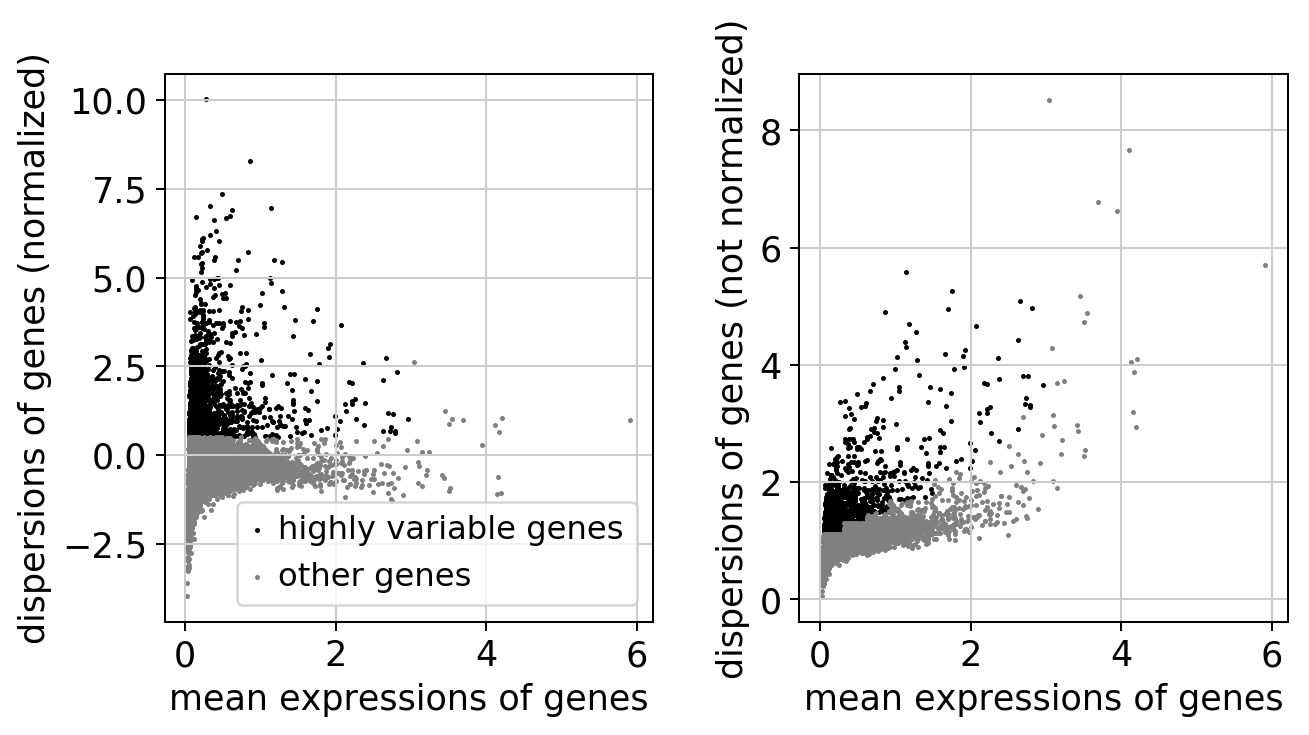

In [26]:
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [27]:
np.sum(adata.var['highly_variable'])

2207

In [34]:
sc.pp.scale(adata, max_value=10)

In [35]:
sc.tl.pca(adata, svd_solver='arpack')

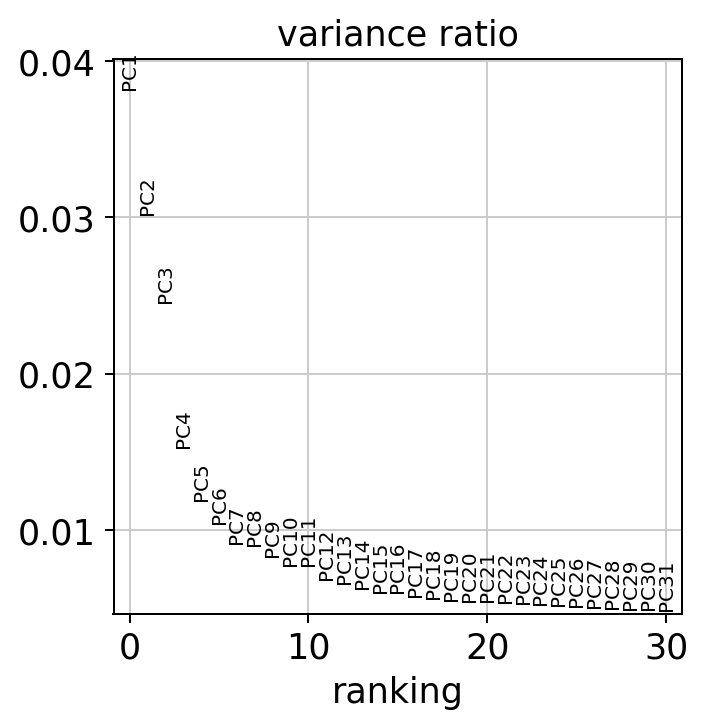

In [36]:
sc.pl.pca_variance_ratio(adata, log = False)

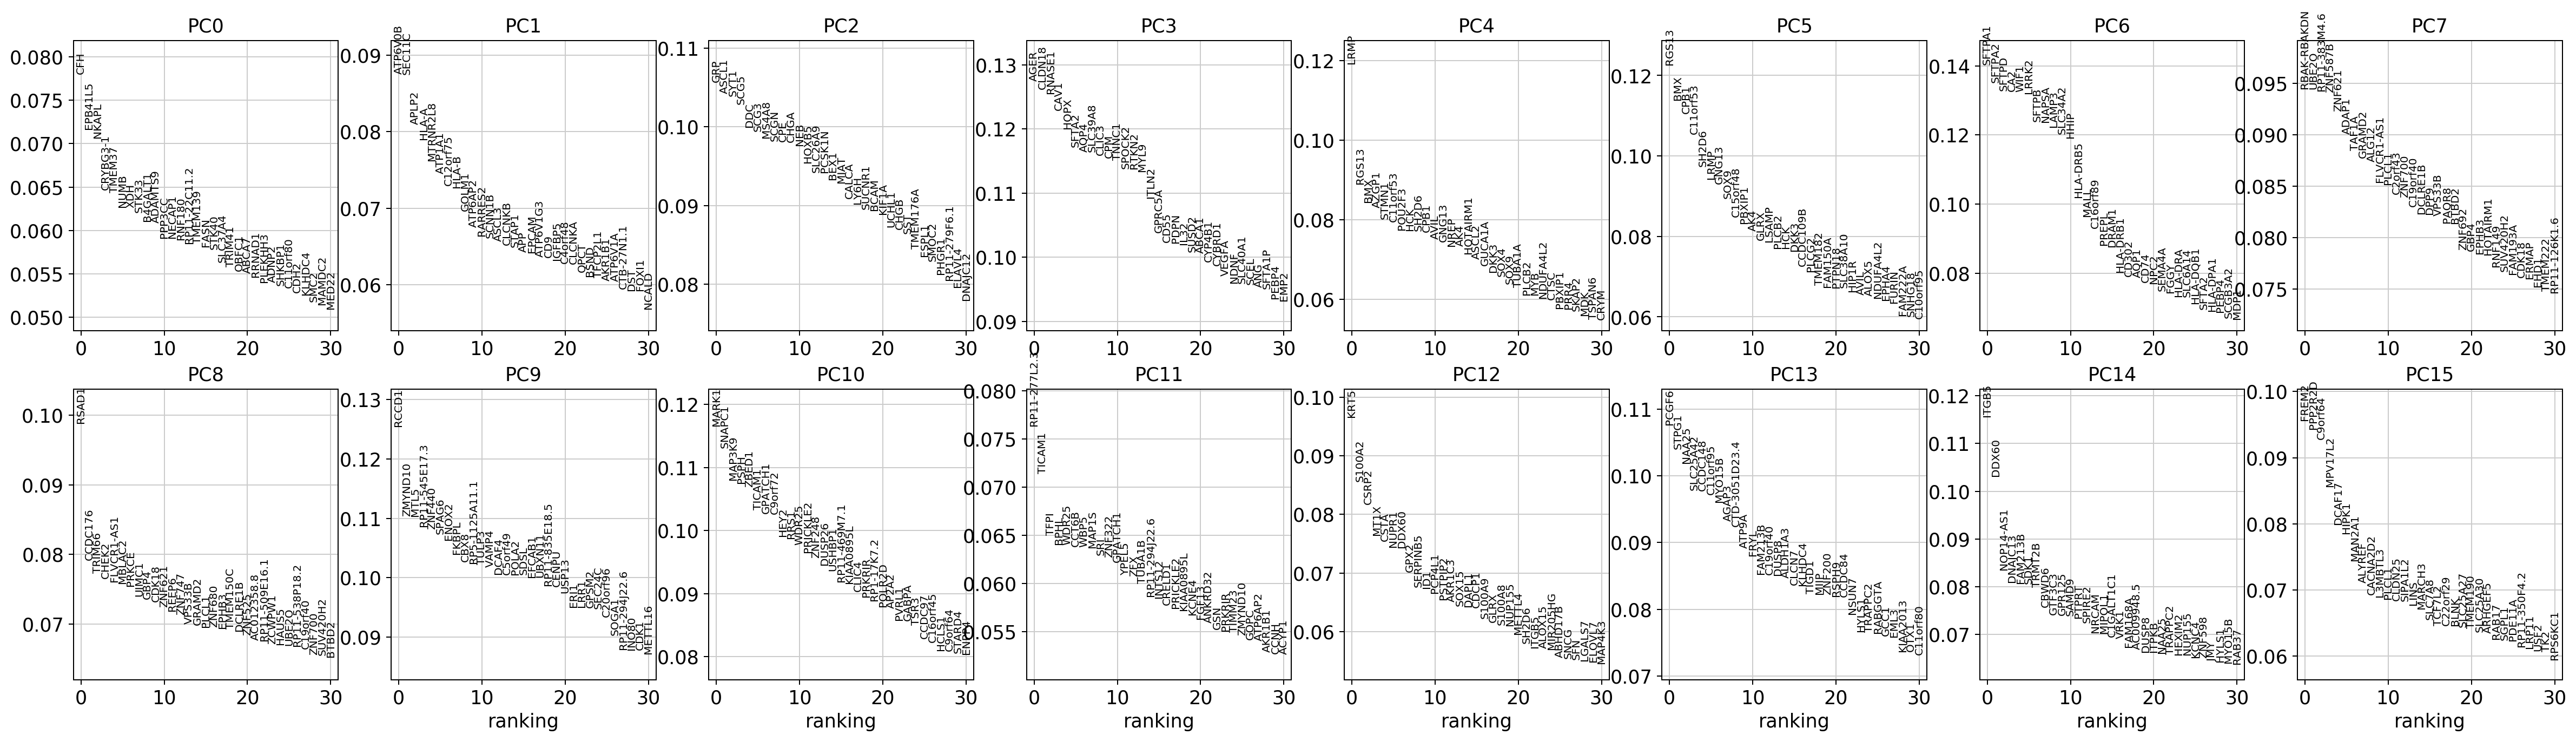

In [37]:
sc.pl.pca_loadings(adata, components=list(range(0,16)))

### Embedding

In [38]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=12)

computing neighbors
    using 'X_pca' with n_pcs = 12
    finished (0:00:00.05) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [39]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:00.70) --> added
    'X_umap', UMAP coordinates (adata.obsm)


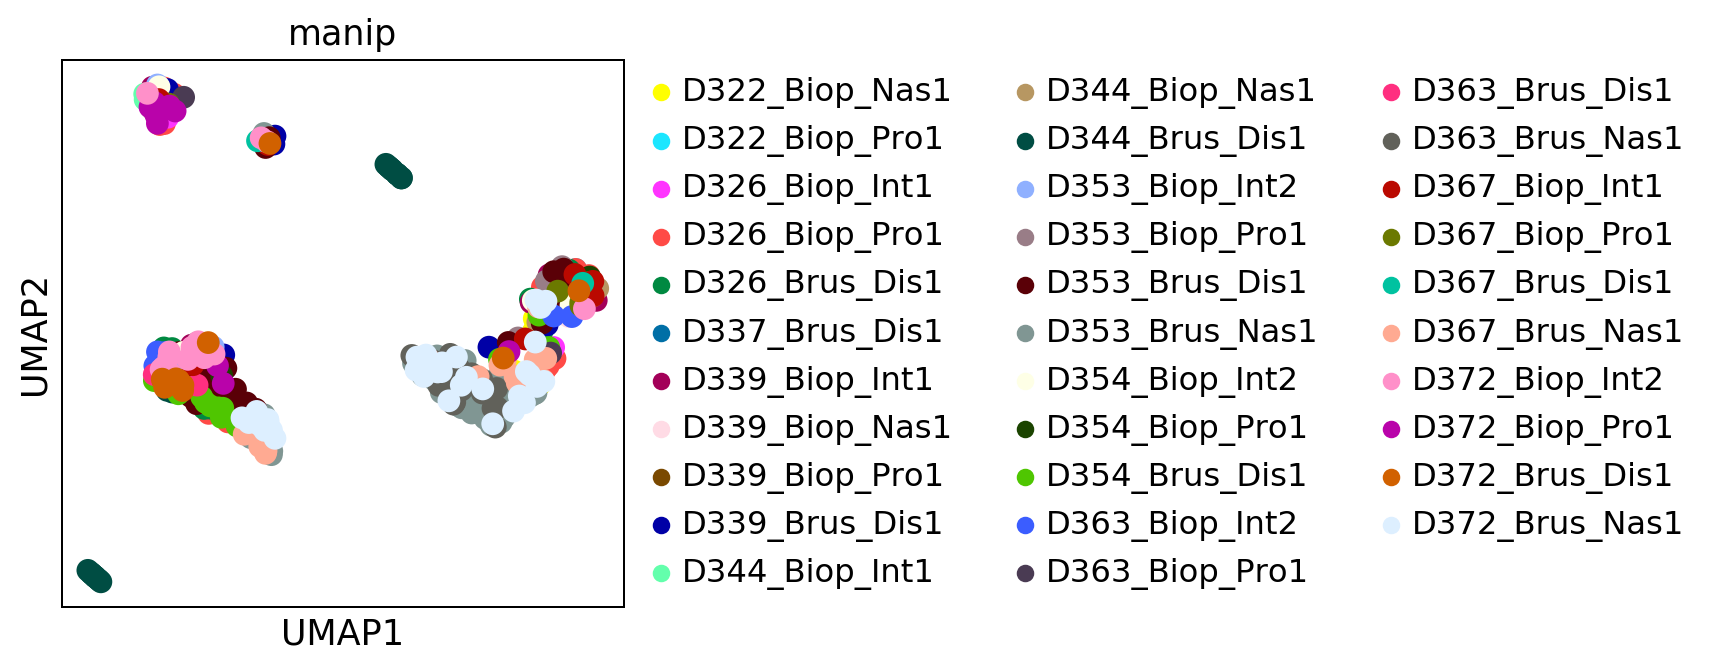

In [40]:
sc.pl.umap(adata, color=['manip'], edges = False)

In [143]:
sc.tl.tsne(adata, n_pcs = 12)

computing tSNE
    using 'X_pca' with n_pcs = 12
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:01.33) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


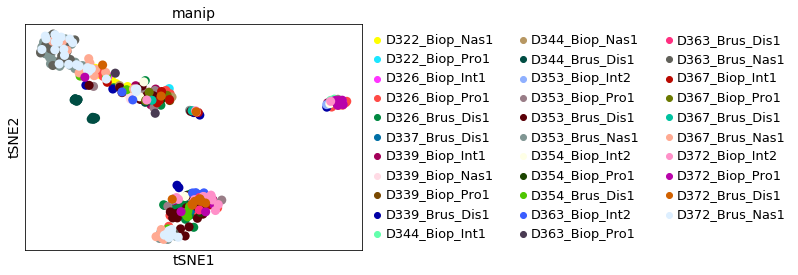

In [144]:
sc.pl.tsne(adata, color=['manip'])

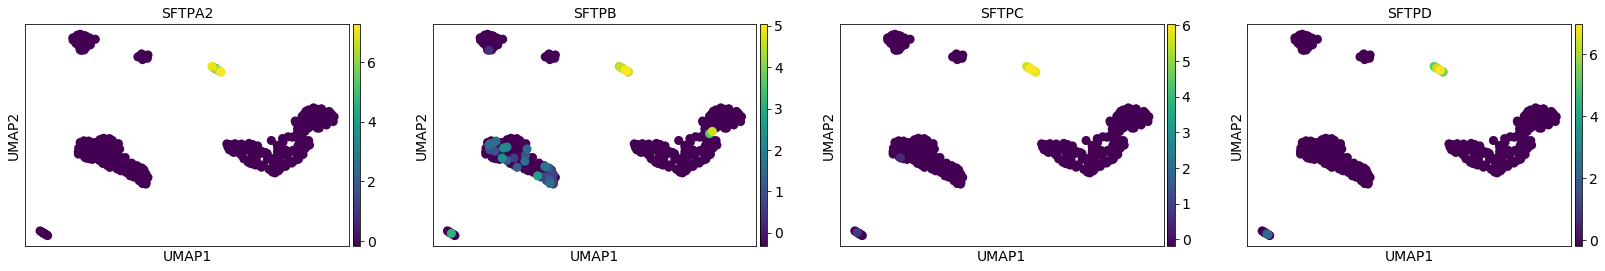

In [145]:
sc.pl.umap(adata, color=['SFTPA2', 'SFTPB', 'SFTPC', 'SFTPD'],edges = False)

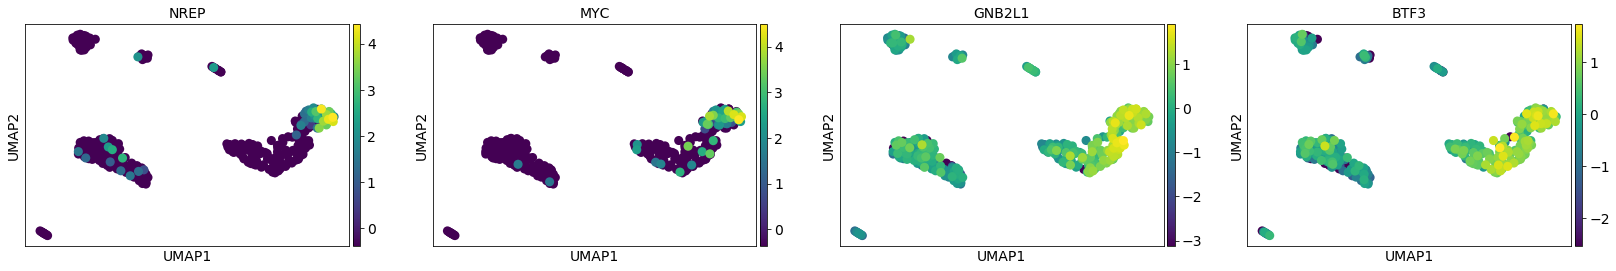

In [146]:
sc.pl.umap(adata, color=['NREP', 'MYC', 'GNB2L1', 'BTF3'],edges = False)

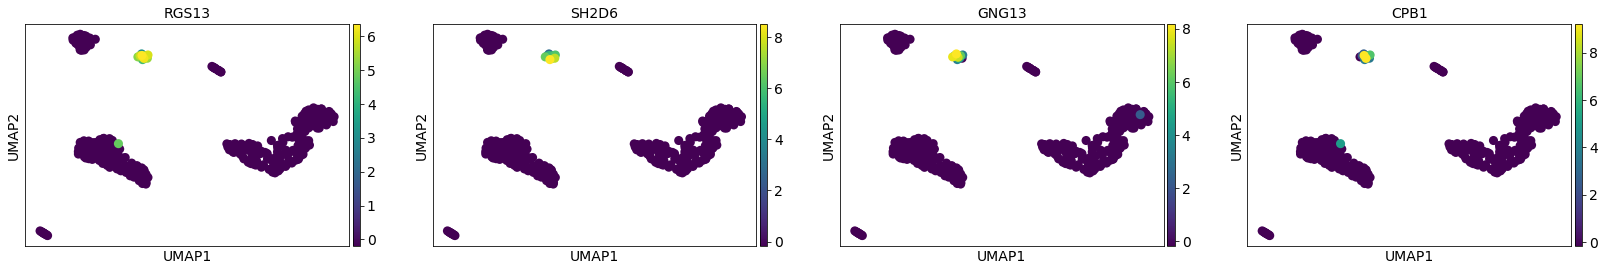

In [147]:
sc.pl.umap(adata, color=['RGS13', 'SH2D6', 'GNG13', 'CPB1'],edges = False)

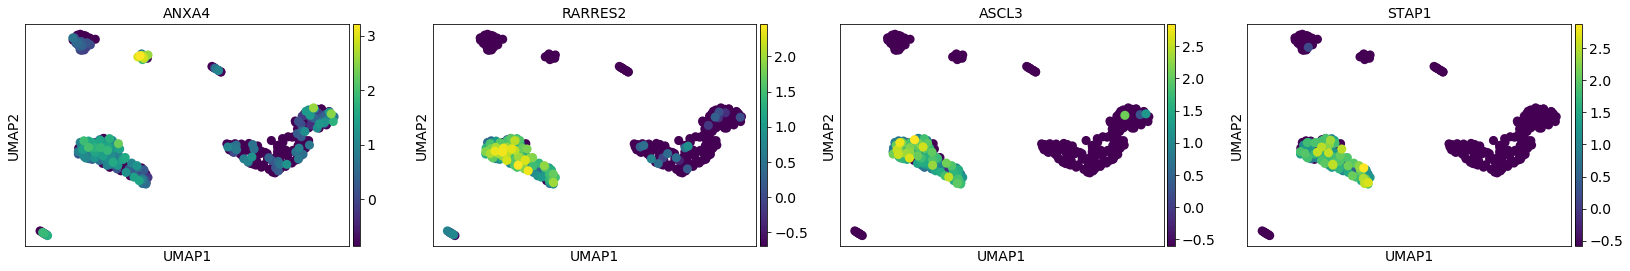

In [148]:
sc.pl.umap(adata, color=['ANXA4', 'RARRES2', 'ASCL3', 'STAP1'],edges = False)

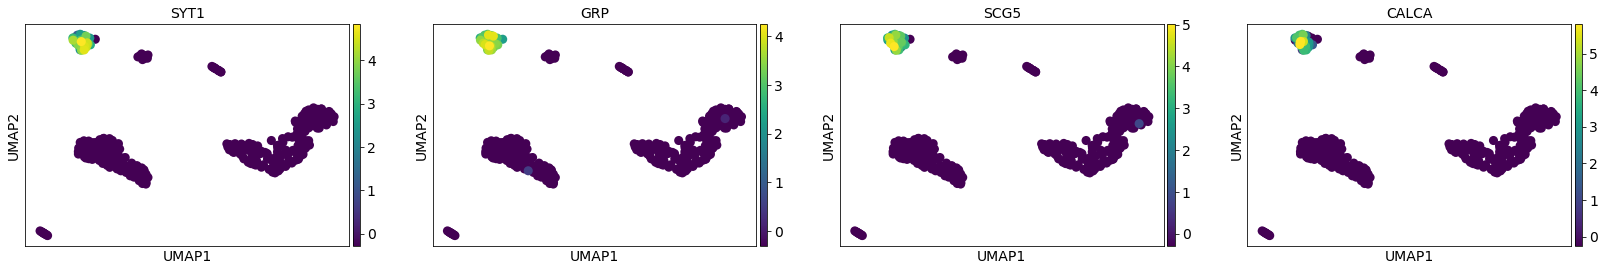

In [149]:
sc.pl.umap(adata, color=['SYT1', 'GRP', 'SCG5', 'CALCA'],edges = False)

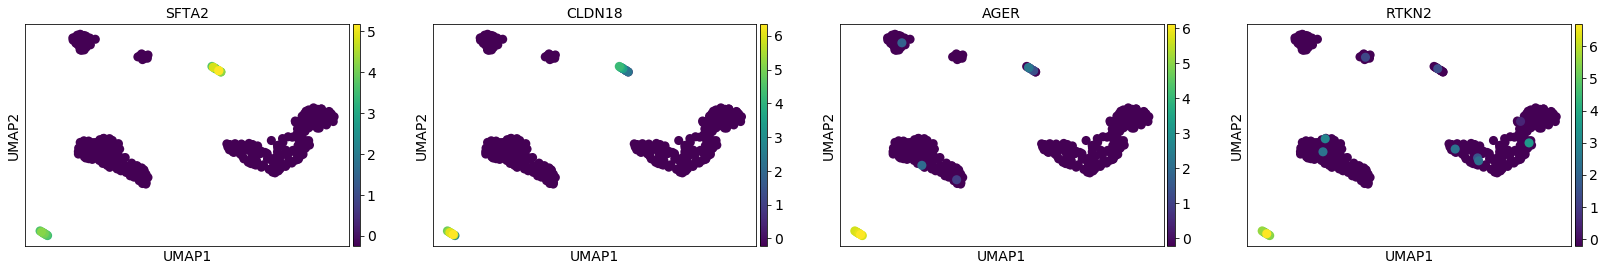

In [150]:
sc.pl.umap(adata, color=['SFTA2', 'CLDN18', 'AGER', 'RTKN2'],edges = False)

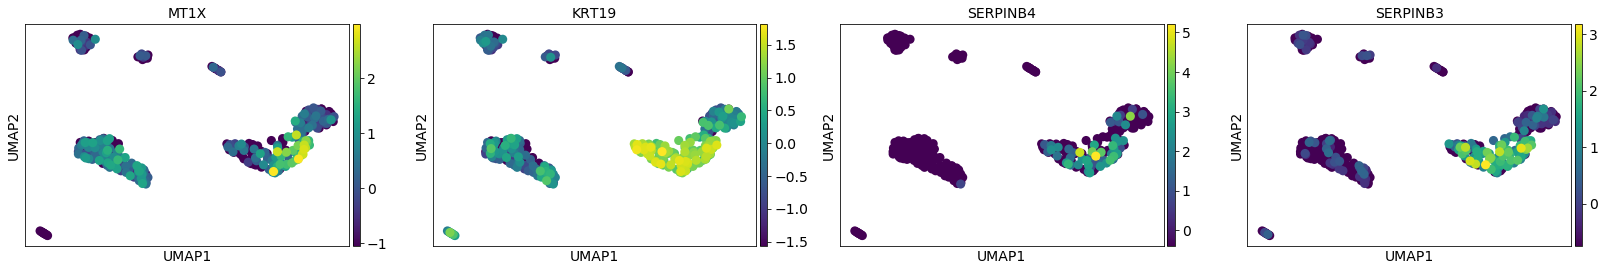

In [151]:
sc.pl.umap(adata, color=['MT1X', 'KRT19', 'SERPINB4', 'SERPINB3'],edges = False)

## Clustering

In [41]:
communities, graph, Q = sc.external.tl.phenograph(adata.obsm['X_pca'][:,0:12], k=10)

PhenoGraph clustering
Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.20628118515014648 seconds
Jaccard graph constructed in 0.6136538982391357 seconds
Wrote graph to binary file in 0.007794857025146484 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.8615
After 4 runs, maximum modularity is Q = 0.863368
Louvain completed 24 runs in 5.0882909297943115 seconds
PhenoGraph complete in 5.926580190658569 seconds
    finished (0:00:06.05)


In [42]:
adata.obs['phenograph'] = pd.Categorical(communities)

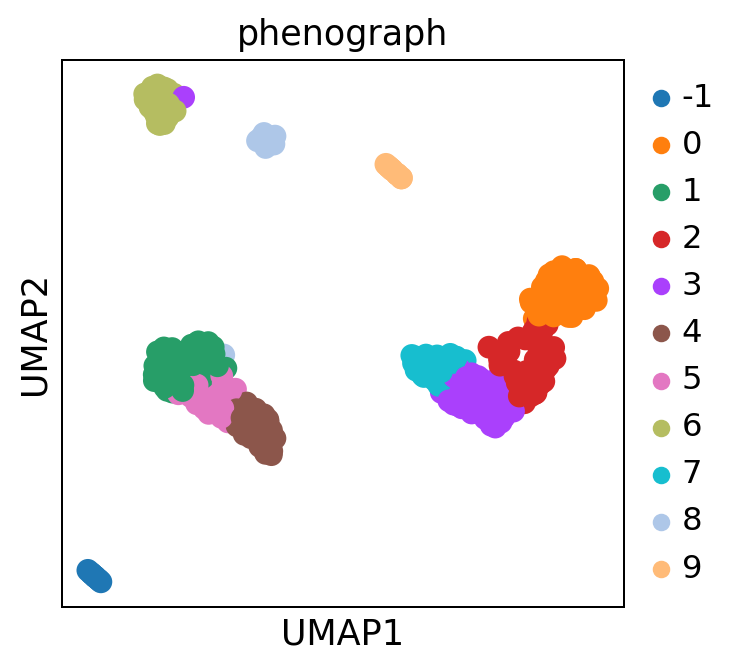

In [43]:
sc.pl.umap(adata, color=['phenograph'])

In [44]:
adata.raw = adata
mean_cellType = np.empty((len(adata.obs['phenograph'].unique()), adata.raw.shape[1]), 
                           dtype=float, order='C')
raw_adata = adata.raw.X

for i in range(0, len(adata.obs['phenograph'].unique())):
    #print(adata.obs['phenograph'].unique()[i])
    mean_cellType[i,:] = np.mean(raw_adata[adata.obs['phenograph'] == adata.obs['phenograph'].unique()[i], :], axis = 0)

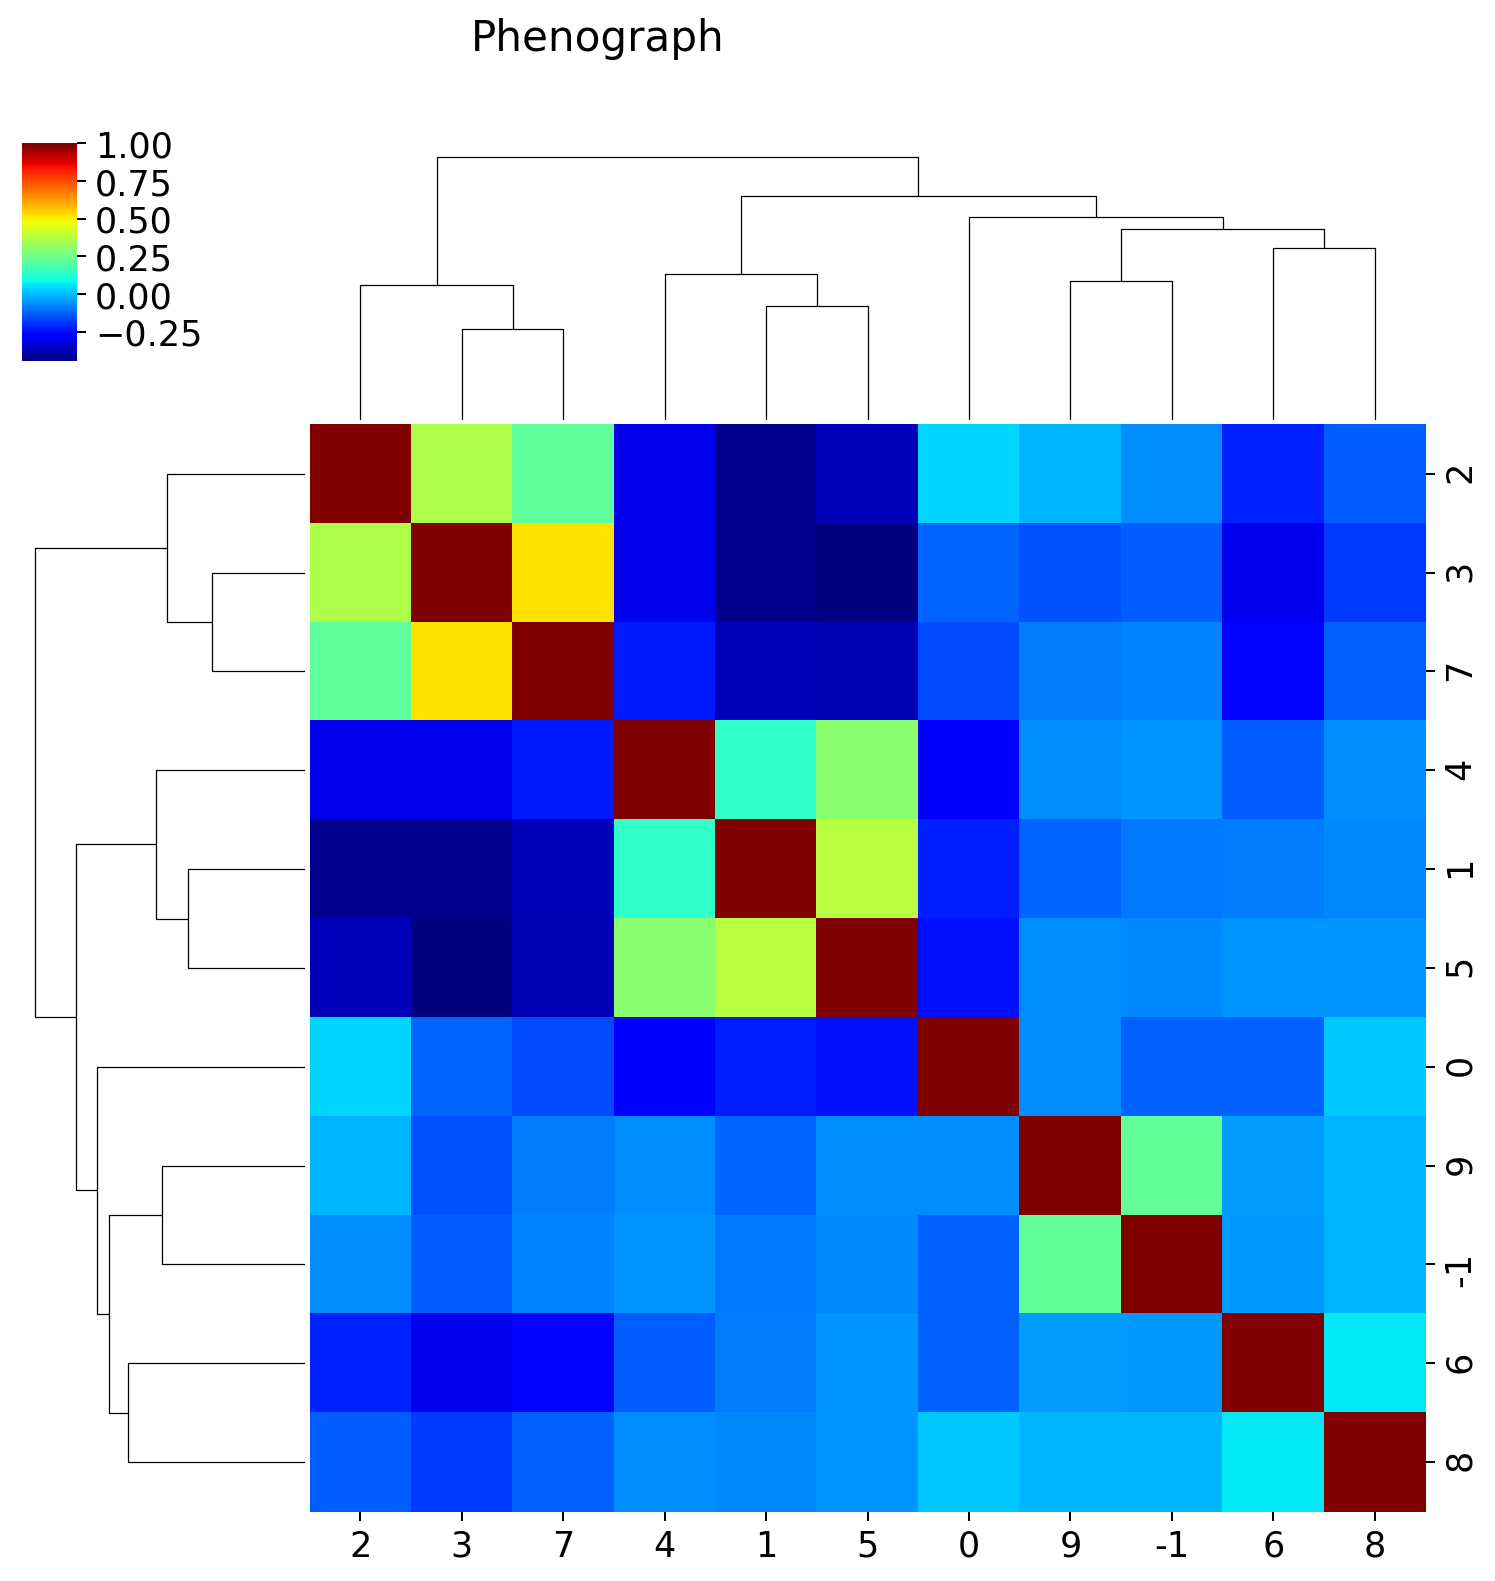

In [45]:
mean_df = pd.DataFrame(np.corrcoef(mean_cellType), index = adata.obs['phenograph'].unique(), columns = adata.obs['phenograph'].unique())

ax = seaborn.clustermap(mean_df, cmap="jet").fig.suptitle('Phenograph') 

In [46]:
sc.tl.rank_genes_groups(adata, groupby = 'phenograph', method='wilcoxon')

ranking genes
    finished (0:00:01.97) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


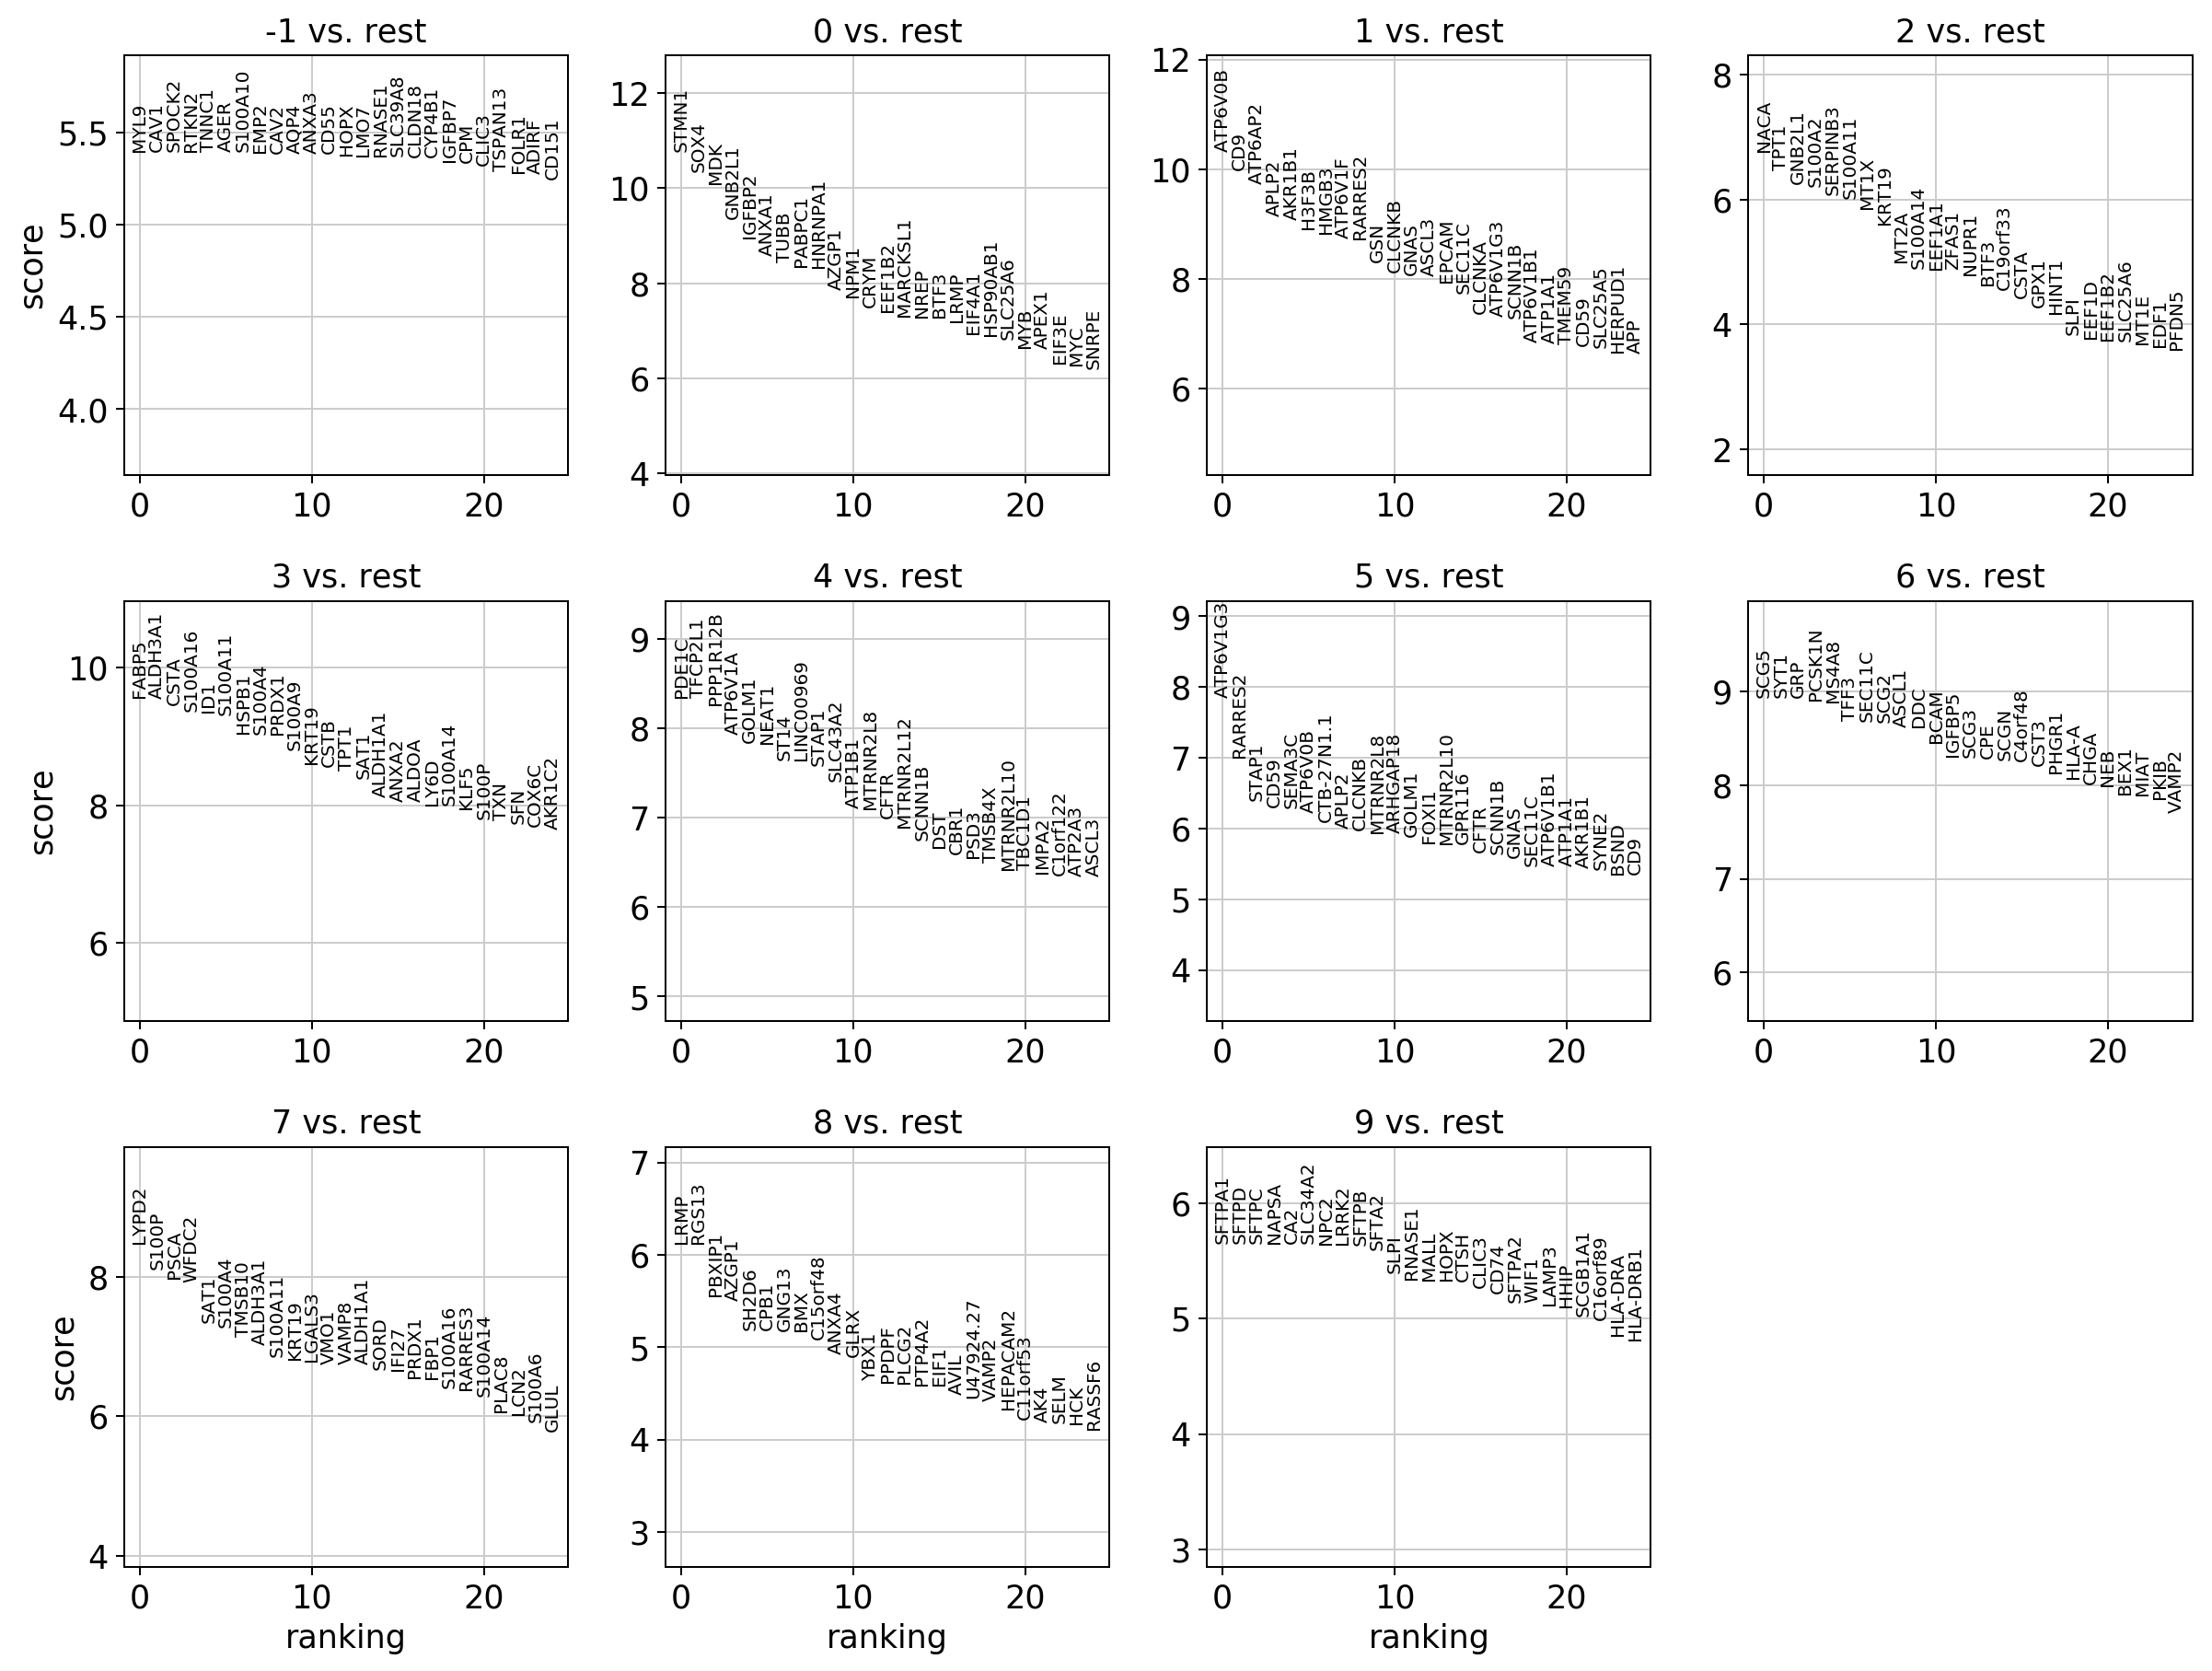

In [47]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

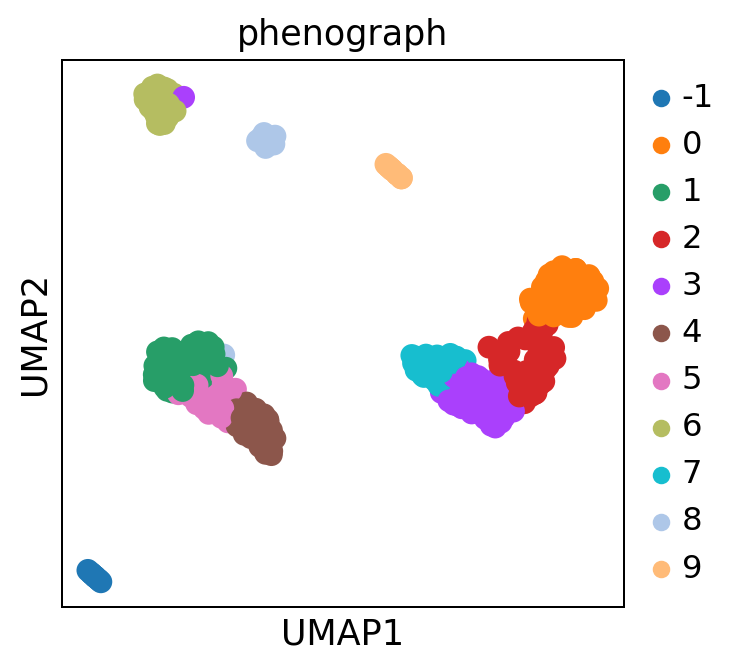

In [48]:
sc.pl.umap(adata, color=['phenograph'])

In [49]:
new_cluster_names = {'-1':'AT1',
    '0':'Precursor', '1':'Ionocyte', '2':'Suprabasal N', '3':'Suprabasal N', '4':'Ionocyte', # 0-4
    '5':'Ionocyte','6':'PNEC', '7':'Suprabasal N', '8':'Brush cells', '9':'AT2' # 5-9
                    }


In [50]:
vect = []
for i in range(0, len(adata.obs['phenograph'])):
    vect = vect + [new_cluster_names[str(adata.obs['phenograph'][i])]]
    
adata.obs['cell_type_detail'] = vect

... storing 'cell_type_detail' as categorical


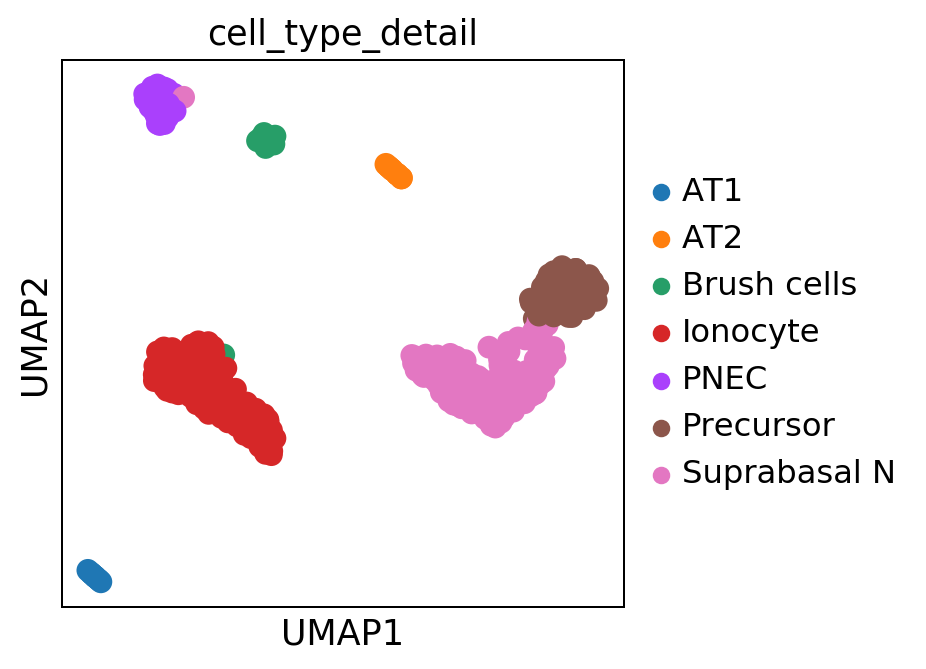

In [51]:
sc.pl.umap(adata, color=['cell_type_detail'])

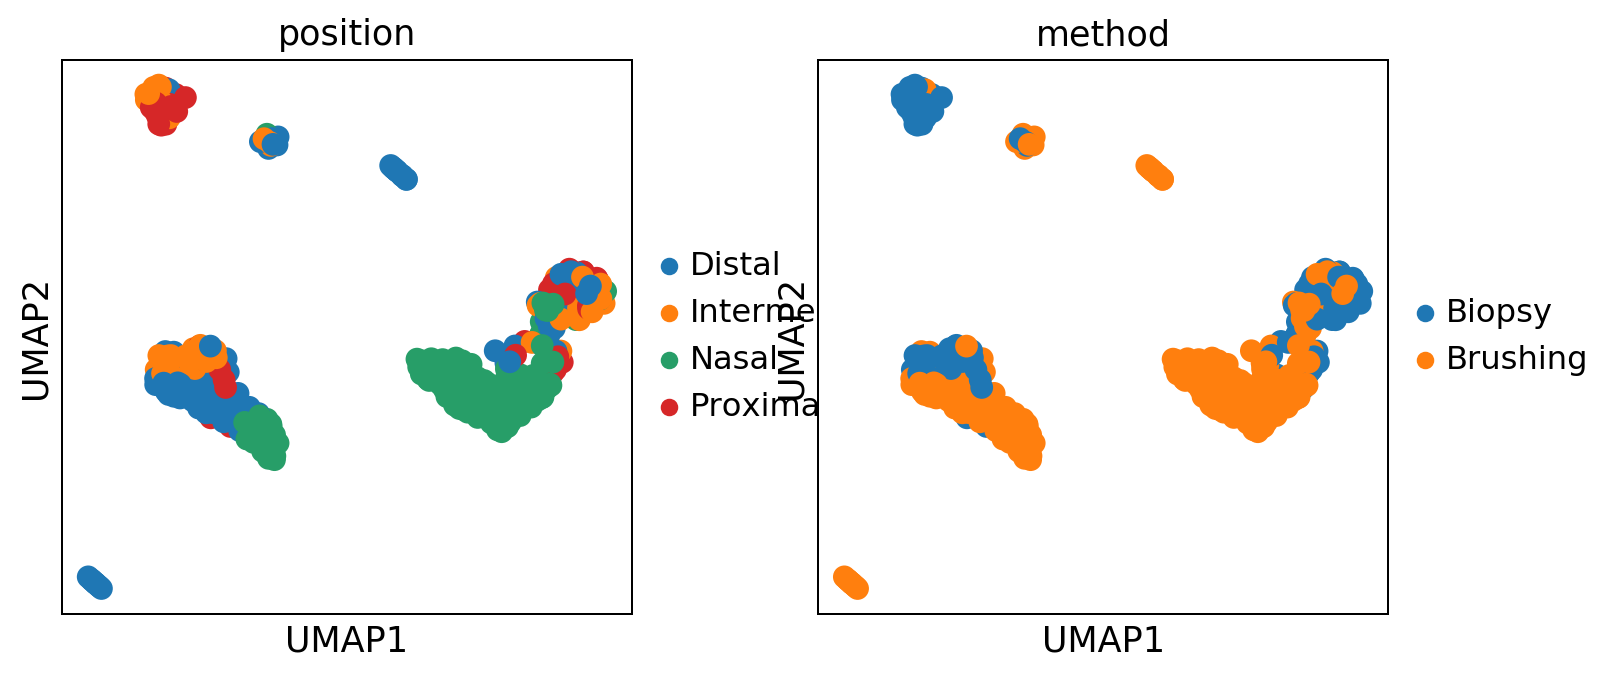

In [52]:
sc.pl.umap(adata, color=['position', 'method'])

In [53]:
list_of_cell_names = adata.obs.loc[adata.obs['cell_type_detail'] != 'Suprabasal N', :].index.tolist()
adata_rare = adata[list_of_cell_names, ]
adata_rare.shape

(243, 10360)

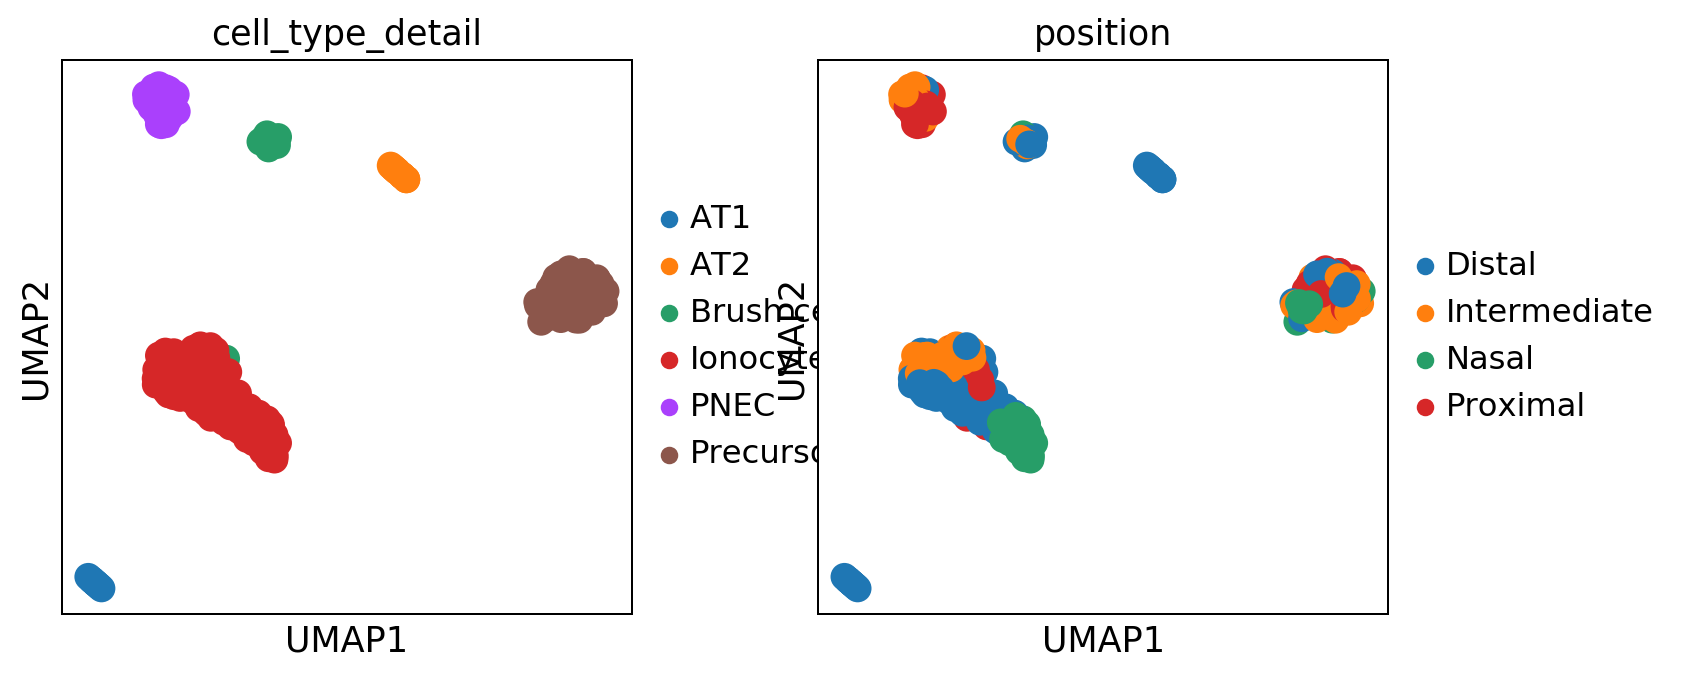

In [54]:
sc.pl.umap(adata_rare, color=['cell_type_detail', 'position'])

In [206]:
adata_rare.obs['umap_1'] = pd.DataFrame(adata_rare.obsm['X_umap']).iloc[:,0]
adata_rare.obs['umap_2'] = pd.DataFrame(adata_rare.obsm['X_umap']).iloc[:,1]
adata_rare.obs.to_csv(path_or_buf = '/Data/Focus_rare_cells_metadata.tsv', 
               sep = '\t', index = True)

In [25]:
coords = pd.DataFrame(adata.obsm['X_umap'])
coords.index = adata.obs.index
coords.shape
coords.to_csv(path_or_buf = '/Data/Focus_rare_cells_umap_coord.tsv', 
               sep = '\t', index = True)

In [58]:
adata_rare.write('/Data/Focus_rare_cells.h5ad')